In [2]:
import pandas as pd
import numpy as np
import warnings
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.model_selection import RepeatedKFold
from sklearn.preprocessing import OneHotEncoder, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import VotingRegressor
from skopt import BayesSearchCV
import joblib

# Suppress warnings
warnings.filterwarnings("ignore")

# Load dataset
data = pd.read_csv("../train_dataset.csv")

# Drop irrelevant or data-leak columns
data = data.drop(columns=['Student ID', 'Mentor-1', 'Mentor-2', 'Mentor-3', 'Roll-2', 'Roll-3',
                          'DE Theory', 'DE Practical', 'FSD Theory', 'FSD Practical',
                          'Python Theory', 'Python Practical', 'Communication Theory', 'Law Theory'])

# Feature Engineering: Semester Percentages
sem1_cols = ['Math-1 Theory', 'Physics Theory', 'Java-1 Theory', 'Software Engineering Theory']
data['Semester1_Percentage'] = data[sem1_cols].mean(axis=1)

sem2_cols = ['Math-2 Theory', 'Data Structures using Java Theory', 'DBMS Theory',
             'Fundamental of Electronics and Electrical Theory', 'Java-2 Theory']
data['Semester2_Percentage'] = data[sem2_cols].mean(axis=1)

# Round percentages for clarity
data['Semester1_Percentage'] = data['Semester1_Percentage'].round(2)
data['Semester2_Percentage'] = data['Semester2_Percentage'].round(2)

# Rename divisions to sections
data = data.rename(columns={'Div-1': 'Section_1', 'Div-2': 'Section_2', 'Div-3': 'Section_3'})

# Extract department letters from section fields
for section in ['Section_1', 'Section_2', 'Section_3']:
    data[section] = data[section].str[0]

# Define target and features
target = 'Math-3 Theory'
features = data.drop(columns=[target])
labels = data[target]

# Identify categorical and numeric columns
categorical_features = ['Gender', 'Religion', 'Branch', 'Section_1', 'Section_2', 'Section_3']
numeric_features = [col for col in features.columns if col not in categorical_features]

# Preprocessing pipeline
preprocessing_pipeline = ColumnTransformer(
    transformers=[
        ('categorical', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_features),
        ('numerical', RobustScaler(), numeric_features)
    ]
)

# Models and pipelines
ridge_pipeline = Pipeline([('preprocessor', preprocessing_pipeline), ('regressor', Ridge())])
lasso_pipeline = Pipeline([('preprocessor', preprocessing_pipeline), ('regressor', Lasso(max_iter=10000))])
elastic_pipeline = Pipeline([('preprocessor', preprocessing_pipeline), ('regressor', ElasticNet(max_iter=10000))])

# Cross-validation strategy
cv = RepeatedKFold(n_splits=5, n_repeats=5, random_state=42)

# Bayesian Optimization
param_grid = {
    'ridge': {'regressor__alpha': (1e-3, 1e3, 'log-uniform')},
    'lasso': {'regressor__alpha': (1e-3, 1e3, 'log-uniform')},
    'elastic': {
        'regressor__alpha': (1e-3, 1e3, 'log-uniform'),
        'regressor__l1_ratio': (0.05, 1.0, 'uniform')
    }
}

# Ridge Optimization
ridge_search = BayesSearchCV(ridge_pipeline, param_grid['ridge'], n_iter=50, cv=cv, scoring='neg_mean_absolute_error', random_state=42)
ridge_search.fit(features, labels)

# Lasso Optimization
lasso_search = BayesSearchCV(lasso_pipeline, param_grid['lasso'], n_iter=50, cv=cv, scoring='neg_mean_absolute_error', random_state=42)
lasso_search.fit(features, labels)

# ElasticNet Optimization
elastic_search = BayesSearchCV(elastic_pipeline, param_grid['elastic'], n_iter=50, cv=cv, scoring='neg_mean_absolute_error', random_state=42)
elastic_search.fit(features, labels)

# Ensemble Model
ensemble_model = VotingRegressor([
    ('ridge', ridge_search.best_estimator_),
    ('lasso', lasso_search.best_estimator_),
    ('elastic', elastic_search.best_estimator_)
])
ensemble_model.fit(features, labels)

# Save the model
joblib.dump(ensemble_model, "math3_model.joblib")


['math3_model.joblib']

In [1]:
# Import the required functions from math3_predictor.py
from math3_predictor import predict_from_dataframe
import pandas as pd

# Load the test data
new_data = pd.read_csv("../test_dataset.csv")

# Predict
predictions = predict_from_dataframe(new_data)

# Output predictions
print(predictions.head())


0    81.087091
1    45.885833
2    60.605432
3    66.208316
4    66.947500
Name: Predicted Values, dtype: float64


Mean Absolute Error (MAE): 6.975324452237738


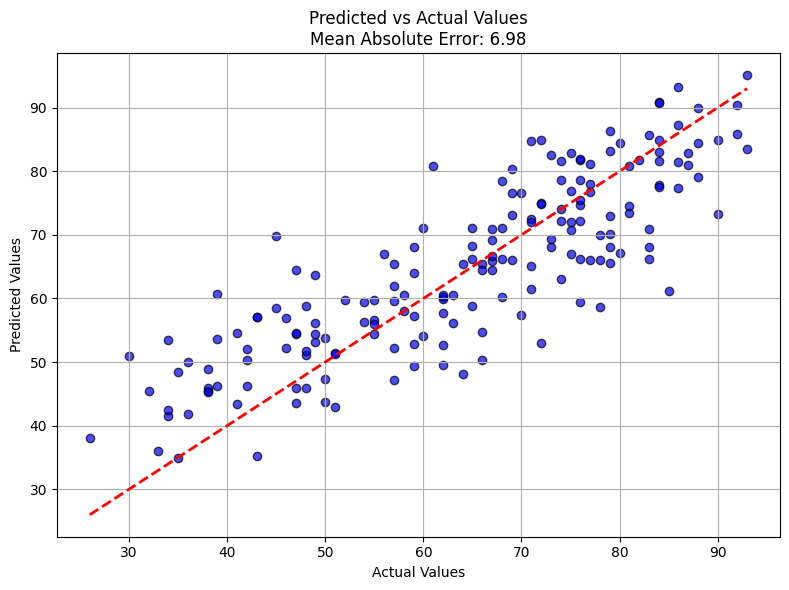

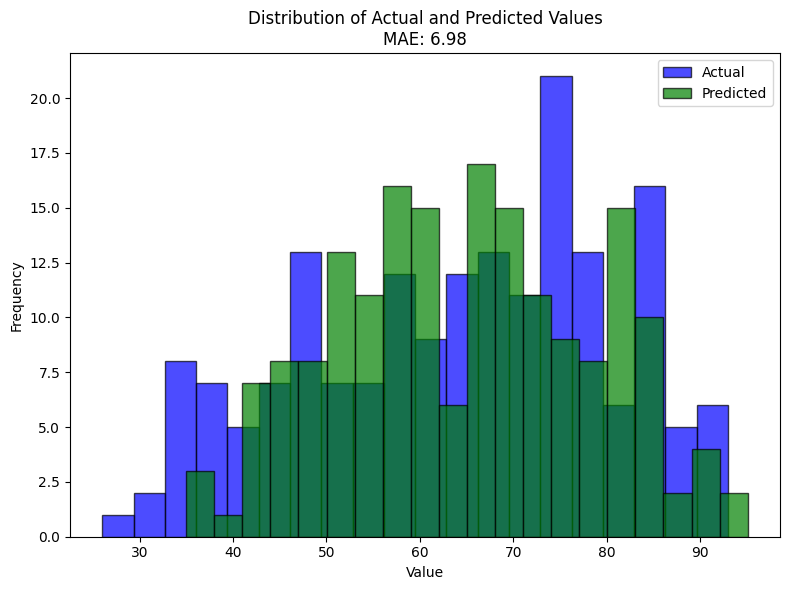

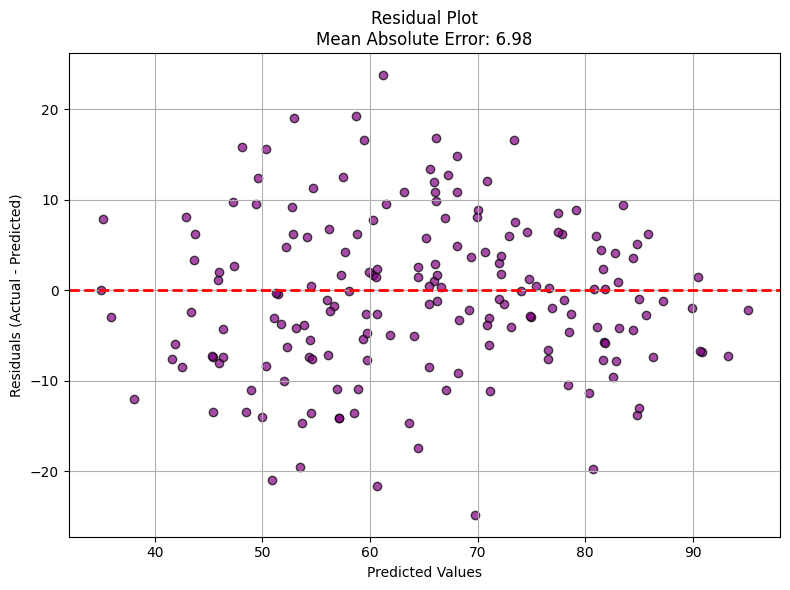

In [3]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from math3_predictor import predict_from_dataframe

# Ensure the 'images' folder exists
os.makedirs("images", exist_ok=True)

# Load the test data
test_data = pd.read_csv("../test_dataset.csv")

# Extract true target values
true_values = test_data['Math-3 Theory']

# Predict using the model
predicted_values = predict_from_dataframe(test_data)

# Calculate Mean Absolute Error
mae = mean_absolute_error(true_values, predicted_values)
print(f"Mean Absolute Error (MAE): {mae}")

# Create a scatter plot of predicted vs. actual values
plt.figure(figsize=(8, 6))
plt.scatter(true_values, predicted_values, alpha=0.7, color='blue', edgecolor='k')
plt.plot([true_values.min(), true_values.max()], [true_values.min(), true_values.max()], 'r--', linewidth=2)
plt.title(f"Predicted vs Actual Values\nMean Absolute Error: {mae:.2f}")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.grid(True)
plt.tight_layout()
plt.savefig("images/predicted_vs_actual.png")
plt.show()

# Additional EDA
# 1. Distribution of True Values
plt.figure(figsize=(8, 6))
plt.hist(true_values, bins=20, alpha=0.7, label="Actual", color="blue", edgecolor="k")
plt.hist(predicted_values, bins=20, alpha=0.7, label="Predicted", color="green", edgecolor="k")
plt.title(f"Distribution of Actual and Predicted Values\nMAE: {mae:.2f}")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.legend()
plt.tight_layout()
plt.savefig("images/distribution_plot.png")
plt.show()

# 2. Residual Plot
residuals = true_values - predicted_values
plt.figure(figsize=(8, 6))
plt.scatter(predicted_values, residuals, alpha=0.7, color='purple', edgecolor='k')
plt.axhline(0, color='r', linestyle='--', linewidth=2)
plt.title(f"Residual Plot\nMean Absolute Error: {mae:.2f}")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals (Actual - Predicted)")
plt.grid(True)
plt.tight_layout()
plt.savefig("images/residual_plot.png")
plt.show()
